In [48]:
import sys

sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

from DA_PoC.common.observation_operator import (
    RandomObservationOperator,
    IdentityObservationOperator,
    LinearObervationOperator,
)
from DA_PoC.dynamical_systems.lorenz_numerical_model import (
    LorenzWrapper,
    create_lorenz_model_observation,
    burn_model,
)
from DA_PoC.variational.incrementalCG import (
    Incremental4DVarCG, pad_ragged
)

plt.set_cmap("magma")


<Figure size 576x396 with 0 Axes>

In [49]:
rng = np.random.default_rng(seed=93)

n = 100
lorenz = LorenzWrapper(n)
lorenz.lorenz_model.dt = 0.01
assimilation_window = [0.05, 0.4, 0.6, 0.8]  # 6 hours, 48 hours, 72 hours, 96 hours
F = 8
assimilation_window_timesteps = [
    int(wind / lorenz.lorenz_model.dt) for wind in assimilation_window
]
nobs = assimilation_window_timesteps[1]

sigma_b_sq = (0.04 * F) ** 2 + (0.1 * np.abs(0 - F)) ** 2
charac_length = 1.5
background_correlation = lambda x, y: np.exp(-((x - y) ** 2) / charac_length**2)
x, y = np.meshgrid(np.arange(n), np.arange(n))

B = sigma_b_sq * background_correlation(x, y)
B_half = np.linalg.cholesky(B)
B_inv = np.linalg.inv(B)

sigma_obs_sq = (0.04 * F) ** 2 + (0.1 * np.abs(0 - F)) ** 2
R = sigma_obs_sq * np.eye(n)
R_half = np.linalg.cholesky(R)

lorenz.background_error_cov_inv = B_inv
lorenz.background = np.zeros(n)

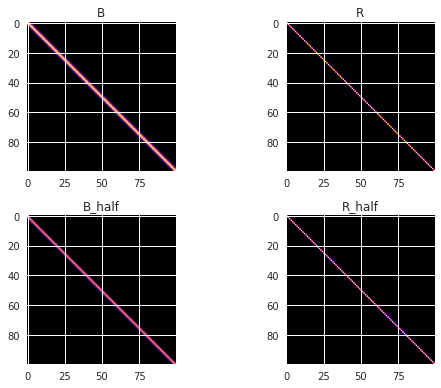

In [50]:
plt.subplot(2, 2, 1)
plt.imshow(B)
plt.title("B")
plt.subplot(2, 2, 2)
plt.imshow(R)
plt.title("R")
plt.subplot(2, 2, 3)
plt.imshow(B_half)
plt.title("B_half")
plt.subplot(2, 2, 4)
plt.imshow(R_half)
plt.title("R_half")
plt.tight_layout()

In [51]:
lorenz = LorenzWrapper(n)
x0_t = burn_model(n, 1000)
lorenz.n_total_obs = nobs

(4100,)

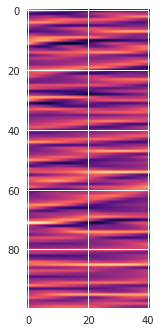

In [52]:
history = lorenz.lorenz_model.integrate(0, x0_t, nobs)
plt.imshow(history[1])
history[1].flatten().shape

In [53]:
n_observed = 1000#history[1].flatten().shape[0]
observed_elts = np.random.choice(
    np.arange(len(history[1].flatten())), size=n_observed, replace=False
)


In [54]:
H_rnd = np.zeros((n_observed, len(history[1].flatten())))
for i, rn in enumerate(np.sort(observed_elts)):
    H_rnd[i, rn] = 1.0

lorenz.H = lambda x: H_rnd @ x.flatten()

In [55]:
tlm = lorenz.lorenz_model.construct_tlm_matrix(0, x0_t, nobs)
tlm = tlm.reshape(-1, n)
tlm.shape


(4100, 100)

In [56]:
lorenz.set_observations(nobs)
lorenz.obs.shape


(4100,)

In [57]:
lorenz.background_error_cov_inv = np.linalg.inv(B)

In [58]:
lorenz.background_error_cov_inv is None

False

(1.0, 313.19522425676286)
316.77975368103347


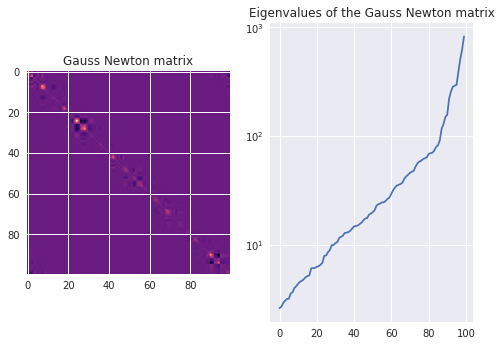

In [59]:
GN_matrix = (tlm.T @ H_rnd.T) @ (H_rnd @ tlm) + np.linalg.inv(B)
plt.subplot(1, 2, 1)
plt.imshow(GN_matrix)
plt.title('Gauss Newton matrix')
print(np.linalg.slogdet(GN_matrix))
print(np.linalg.cond(GN_matrix))
plt.subplot(1, 2, 2)
plt.plot(np.linalg.eigvalsh(GN_matrix))
plt.title('Eigenvalues of the Gauss Newton matrix')
plt.yscale("log")

Text(0.5, 1.0, 'Non zero entries of the inverse of the GN matrix')

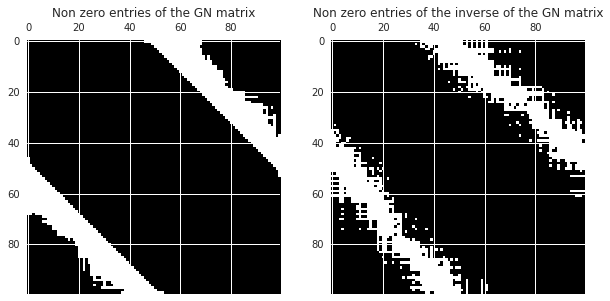

In [60]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.spy(1 - np.isclose(GN_matrix, 0))
plt.title('Non zero entries of the GN matrix')
plt.subplot(1, 2, 2)
plt.spy(1 - np.isclose(np.linalg.inv(GN_matrix), 0))
plt.title('Non zero entries of the inverse of the GN matrix')


In [61]:
def get_next_observations(x_init, lorenz=lorenz, modsigsq=0.5, obssigsq=3, nobs=nobs):
    lorenz.n_total_obs = nobs
    n = lorenz.state_dimension
    truth = np.empty((n, nobs + 1))
    curr_state = x_init
    truth[:, 0] = curr_state
    for i in range(nobs):
        curr_state = lorenz.lorenz_model.integrate(0, curr_state, 1)[1][
            :, 1
        ] + modsigsq * np.random.normal(size=(n))
        truth[:, i + 1] = curr_state
    obs = truth + obssigsq * np.random.normal(size=(n, (nobs + 1)))
    x_t = truth[:, -1]
    return obs, x_t, truth

obs, x_t, truth = get_next_observations(x0_t)


In [62]:
obs.reshape(-1).shape

(4100,)

In [63]:
print(f"Random observation operator   ---------------")
m = n * (nobs + 1)

# random_obs_operator = IdentityObservationOperator(m, m)  # , 0.9, 0)
random_obs_operator = RandomObservationOperator(m, m, type="rect", p=1, p_offdiag=0)
identity_obs_operator = IdentityObservationOperator(m)
hundred_observed = LinearObervationOperator(Hmatrix=H_rnd)
# plt.imshow(random_obs_operator.H)
# m = n * (nobs + 1)

lorenz.H = lambda x: H_rnd @ x
lorenz.set_observations(nobs)
print(lorenz.obs.shape)
l_model_randobs = create_lorenz_model_observation(
    lorenz, hundred_observed, test_consistency=False
)
GN = lorenz.gauss_newton_matrix(x0_t)


Random observation operator   ---------------
(4100,)
Observation operator set already


TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

In [ ]:
lorenz.background = np.zeros(n)
lorenz.background_cost(x0_t)

9986.778724971773

10.802528402403254


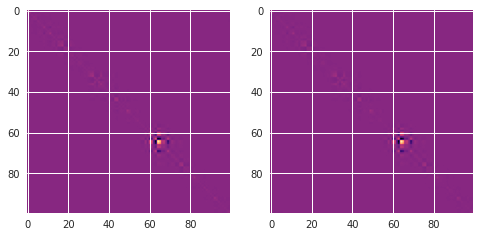

In [ ]:
GN_lmodel = l_model_randobs.gauss_newton_hessian_matrix(x0_t)
GN_matrix = (tlm.T @ H_rnd.T) @ (H_rnd @ tlm) + 
plt.subplot(1, 2, 1)
plt.imshow(GN_lmodel)
plt.subplot(1, 2, 2)
plt.imshow(GN_matrix)


In [ ]:
GN_matrix + np.linalg.inv(B)

array([[129.26272939,  57.52527757, -27.13004521, ..., -20.64645295,
         -0.64774788,  64.81780317],
       [ 57.52527757,  79.31285158, -28.63053501, ...,   7.58605666,
          0.51584075,  -2.16289621],
       [-27.13004521, -28.63053501,  28.51951875, ...,   0.55505431,
         -0.19362699,  -7.15290373],
       ...,
       [-20.64645295,   7.58605666,   0.55505431, ...,  30.70323254,
         -6.60432238, -25.14362039],
       [ -0.64774788,   0.51584075,  -0.19362699, ...,  -6.60432238,
         11.79043825,  -1.90794233],
       [ 64.81780317,  -2.16289621,  -7.15290373, ..., -25.14362039,
         -1.90794233,  71.79202526]])

In [ ]:
(GN_matrix + np.linalg.inv(B) - GN_lmodel)

4.547473508864641e-13

In [ ]:
n_cycle = 3
n_outer = 10
n_inner = 100
# np.random.set_state(7071522)
DA_vanilla = Incremental4DVarCG(
    state_dimension=n,
    bounds=None,
    numerical_model=l_model_randobs,
    observation_operator=hundred_observed,
    x0_t=np.random.normal(size=n),
    get_next_observations=get_next_observations,
    n_cycle=n_cycle,
    n_outer=n_outer,
    n_inner=n_inner,
    prec=None,
    plot=False,
)
# DA_vanilla = data_assimilation(
#     l_model_randobs,
#     random_obs_operator,
#     get_next_observations,
#     n_cycle,
#     n_outer,
#     n_inner,
#     prec=None,
#     plot=False,
# )
# diagnostic_plots(DA_vanilla, "vanilla")
DA_vanilla.run()


niter,     f(x),  CG iter, log-det,   cond


KeyboardInterrupt: 

: log(residuals) = 4.20 +  -0.26 * i
First 20 it, : log(residuals) = 7.87 +  -0.31 * i


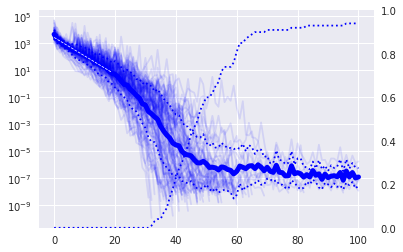

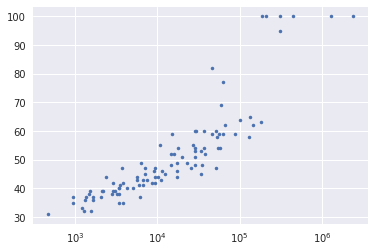

In [ ]:
DA_vanilla.plot_residuals_inner_loop('blue', label='', cumulative=True)
cond, niter = DA_vanilla.extract_condition_niter()
plt.figure()
plt.plot(cond, niter, '.')
plt.xscale('log')


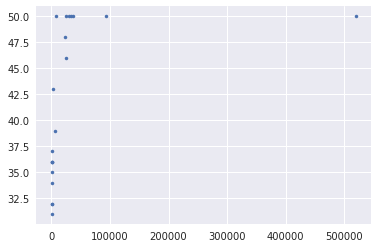

In [ ]:
l_model_randobs.r = n // 10
DA_LMP_10 = data_assimilation(
    l_model_randobs,
    random_obs_operator,
    get_next_observations,
    n_cycle,
    n_outer,
    n_inner,
    prec="spectralLMP",
    plot=False,
)
diagnostic_plots(DA_LMP_10, "LMP 10")


In [ ]:
l_model_randobs.r = n // 20
DA_LMP_5 = data_assimilation(
    l_model_randobs,
    random_obs_operator,
    get_next_observations,
    n_cycle,
    n_outer,
    n_inner,
    prec="spectralLMP",
    plot=False,
)
diagnostic_plots(DA_LMP_5, "LMP 5")


In [ ]:
l_model_randobs.r = n // 50
DA_LMP_2 = data_assimilation(
    l_model_randobs,
    random_obs_operator,
    get_next_observations,
    n_cycle,
    n_outer,
    n_inner,
    prec="spectralLMP",
    plot=False,
)
diagnostic_plots(DA_LMP_2, "LMP 2")


In [ ]:
plot_innerloopiter(DA_vanilla, "blue", "vanilla")
plot_innerloopiter(DA_LMP_10, "red", "LMP 10")
plot_innerloopiter(DA_LMP_5, "magenta", "LMP 5")
plot_innerloopiter(DA_LMP_2, "grey", "LMP 2")
plt.legend()
